[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading the dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.



Initial DataFrame Head:
  Symbol                            Security                  Sector  \
0    UTL                  Unitil Corporation               Utilities   
1     HE  Hawaiian Electric Industries, Inc.               Utilities   
2     MG                 Mistras Group, Inc.  Consumer Discretionary   
3    GNK    Genco Shipping & Trading Limited  Consumer Discretionary   
4     BB                  BlackBerry Limited              Technology   

                                  Industry  \
0                         Power Generation   
1              Electric Utilities: Central   
2            Military/Government/Technical   
3                    Marine Transportation   
4  Computer Software: Prepackaged Software   

                                                 URL                 Date  \
0  https://www.nasdaq.com/articles/safest-high-yi...  2009-10-09 11:48:00   
1  https://www.nasdaq.com/articles/safest-high-yi...  2009-10-09 11:48:00   
2  https://www.nasdaq.com/articles

100%|██████████| 441128/441128 [32:04<00:00, 229.18it/s]



All required columns are present.

Training Set Size: (291008, 49)
Testing Set Size: (62358, 49)

Fitting the final Ridge Regression model with fixed hyperparameters...
Model fitting completed.

Making predictions on the test set with the final model...
Predictions completed.

Final Model Performance on Returns:
Mean Squared Error (MSE): 0.7067
Root Mean Squared Error (RMSE): 0.8406
R-squared (R2 ): 0.0811

Sector-wise Metrics (on Returns):
                    Sector        MSE        R2  Sharpe Ratio
0              Industrials   0.216618  0.285941     -0.058180
1              Health Care   0.922556  0.221544     -0.039214
2   Consumer Discretionary   0.215055  0.151283     -0.061670
3              Real Estate   0.268358 -0.026199      0.136970
4                  Finance   0.753134  0.326008      0.015090
5               Technology   0.422857 -0.057603     -0.042048
6                   Energy   0.054603 -0.554121     -0.322117
7                Utilities   0.903806  0.181042      0.128

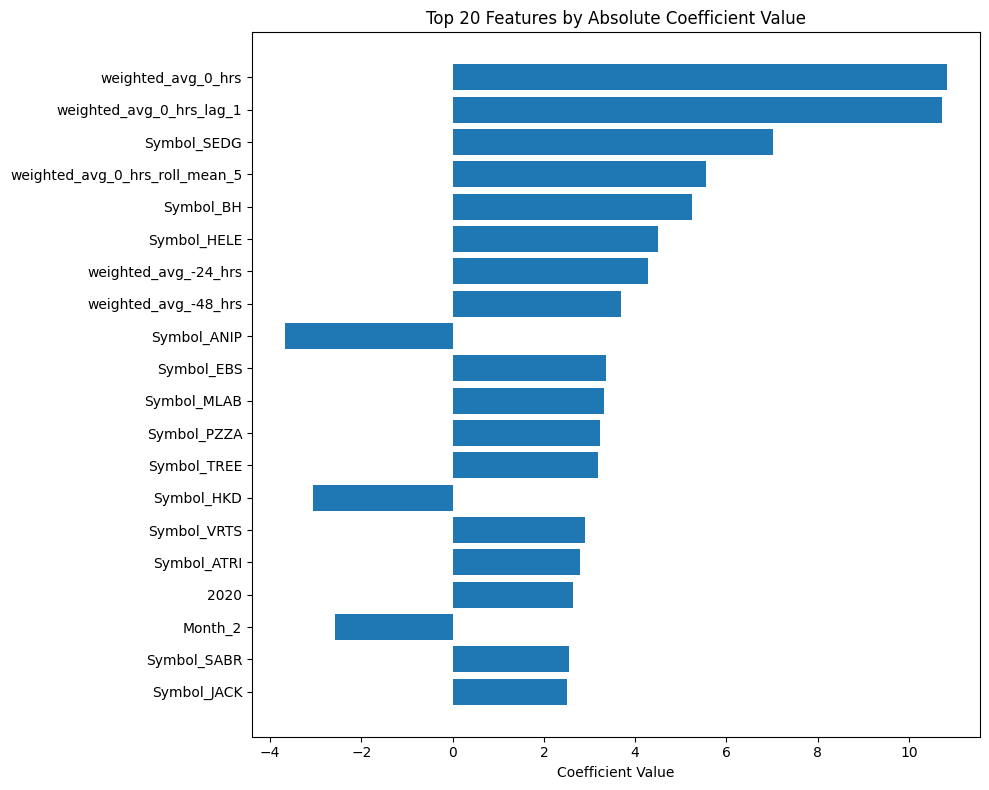

In [1]:
# ---- Install and Import Necessary Libraries ----
!pip install datasets pandas numpy scikit-learn statsmodels nltk tqdm tensorflow joblib matplotlib category_encoders holidays

import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
import warnings
from tqdm import tqdm
import logging
import nltk
import matplotlib.pyplot as plt
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
from joblib import Parallel, delayed

# ---- Configure Logging ----
logging.basicConfig(
    level=logging.INFO,
    filename='model_evaluation.log',
    filemode='w',
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# ---- Suppress Warnings ----
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# ---- Download Necessary NLTK Data ----
nltk.download('vader_lexicon')

# ---- Initialize Sentiment Analyzer ----
sia = SentimentIntensityAnalyzer()

# ---- Function to Compute Sentiment Scores ----
def compute_sentiment(text):
    return sia.polarity_scores(text)['compound']

# ---- Load the Dataset ----
print("Loading the dataset...")
logging.info("Loading the dataset...")
ds = load_dataset("nbettencourt/SC454k")
df = pd.DataFrame(ds['train'])

# Display initial data
print("\nInitial DataFrame Head:")
print(df.head())
print("\nDataFrame Columns:")
print(df.columns)
logging.info(f"Initial DataFrame Head:\n{df.head()}")
logging.info(f"DataFrame Columns:\n{df.columns}")

# ---- Data Preprocessing ----

# Handle Missing Values
# Drop rows where the target 'weighted_avg_720_hrs' or 'weighted_avg_0_hrs' is missing or zero
df = df.dropna(subset=['weighted_avg_720_hrs', 'weighted_avg_0_hrs'])
df = df[df['weighted_avg_0_hrs'] != 0]

# Parse 'Date' Column
df['Date_cleaned'] = df['Date'].astype(str).str.replace(' ET', '', regex=False)
df['Date'] = pd.to_datetime(df['Date_cleaned'], errors='coerce')
df = df.drop(columns=['Date_cleaned'])

# Drop rows with unparsed dates
df = df.dropna(subset=['Date'])

# Sort the DataFrame by 'Symbol' and 'Date' to prepare for per-stock feature engineering
df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

# Convert 'Date' to Unix Timestamp
# Convert 'Date' to Unix timestamp (seconds since epoch)
df['Date_unix'] = df['Date'].astype('int64') // 10**9

# Extract Day of Week, Month, and Year
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Date'].dt.month          # January=1, December=12
df['Year'] = df['Date'].dt.year

# Verify new columns creation
print("\nDataFrame with 'Date_unix', 'DayOfWeek', 'Month', 'Year':")
print(df[['Date', 'Date_unix', 'DayOfWeek', 'Month', 'Year']].head())
logging.info(f"DataFrame with 'Date_unix', 'DayOfWeek', 'Month', 'Year':\n{df[['Date', 'Date_unix', 'DayOfWeek', 'Month', 'Year']].head()}")

# ---- Feature Engineering ----

# Create Lag Features
lag_features = ['weighted_avg_0_hrs']
for lag in [1, 2, 3, 5, 10]:
    df[f'weighted_avg_0_hrs_lag_{lag}'] = df.groupby('Symbol')['weighted_avg_0_hrs'].shift(lag)

# Create Rolling Statistics
window_sizes = [5, 10, 20]
for window in window_sizes:
    df[f'weighted_avg_0_hrs_roll_mean_{window}'] = df.groupby('Symbol')['weighted_avg_0_hrs'].rolling(window).mean().reset_index(0, drop=True)
    df[f'weighted_avg_0_hrs_roll_std_{window}'] = df.groupby('Symbol')['weighted_avg_0_hrs'].rolling(window).std().reset_index(0, drop=True)

# Create Difference Features
df['weighted_avg_0_hrs_diff_1'] = df.groupby('Symbol')['weighted_avg_0_hrs'].diff(1)

# Apply Sentiment Analysis in Parallel
print("\nComputing sentiment scores for 'Title' and 'Article'...")
logging.info("Computing sentiment scores for 'Title' and 'Article'...")

# Parallel computation for 'Title' Sentiment
df['Title_Sentiment'] = Parallel(n_jobs=-1)(
    delayed(compute_sentiment)(text) for text in tqdm(df['Title'])
)

# Parallel computation for 'Article' Sentiment
df['Article_Sentiment'] = Parallel(n_jobs=-1)(
    delayed(compute_sentiment)(text) for text in tqdm(df['Article'])
)

# Drop rows with any NaN values resulting from feature engineering
df = df.dropna().reset_index(drop=True)

# ---- Feature Selection ----
# Define numeric and categorical features
numeric_features = [
    'weighted_avg_-96_hrs',
    'weighted_avg_-48_hrs',
    'weighted_avg_-24_hrs',
    'weighted_avg_0_hrs',
    'Risk_Free_Rate',
    'Date_unix',
    'Year',
    'weighted_avg_0_hrs_lag_1',
    'weighted_avg_0_hrs_lag_2',
    'weighted_avg_0_hrs_lag_3',
    'weighted_avg_0_hrs_lag_5',
    'weighted_avg_0_hrs_lag_10',
    'weighted_avg_0_hrs_roll_mean_5',
    'weighted_avg_0_hrs_roll_std_5',
    'weighted_avg_0_hrs_roll_mean_10',
    'weighted_avg_0_hrs_roll_std_10',
    'weighted_avg_0_hrs_roll_mean_20',
    'weighted_avg_0_hrs_roll_std_20',
    'weighted_avg_0_hrs_diff_1',
    'Title_Sentiment',
    'Article_Sentiment'
]

categorical_features = ['Symbol', 'Sector', 'Industry', 'Author', 'Publication', 'DayOfWeek', 'Month']

# Define text features
text_features = ['Title', 'Article']

target = 'weighted_avg_720_hrs'

required_columns = numeric_features + categorical_features + text_features + [target]
missing_cols = set(required_columns) - set(df.columns)
if missing_cols:
    print(f"\nMissing columns in DataFrame: {missing_cols}")
    logging.warning(f"Missing columns in DataFrame: {missing_cols}")
else:
    print("\nAll required columns are present.")
    logging.info("All required columns are present.")

# ---- Train-Test Split ----

# Determine split indices
total_length = len(df)
train_size = int(total_length * 0.70)  # 70% for training
test_size = int(total_length * 0.15)   # 15% for testing
# update_size = total_length - train_size - test_size  # 15% for updating (not used here)

# Split the data
train_df = df.iloc[:train_size].reset_index(drop=True)
test_df = df.iloc[train_size:train_size + test_size].reset_index(drop=True)

print(f"\nTraining Set Size: {train_df.shape}")
print(f"Testing Set Size: {test_df.shape}")
logging.info(f"Training Set Size: {train_df.shape}")
logging.info(f"Testing Set Size: {test_df.shape}")

# Define training and testing features and targets
X_train = train_df[numeric_features + categorical_features + text_features].copy()
y_train = train_df[target].copy()

X_test = test_df[numeric_features + categorical_features + text_features].copy()
y_test = test_df[target].copy()

# ---- Encode Categorical Variables with One-Hot Encoding ----
# Preprocessing for numeric features: Standard Scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for text features
title_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=750))
])

article_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=1000))
])

# Combine preprocessing for numeric, categorical, and text features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('title_tfidf', title_transformer, 'Title'),
        ('article_tfidf', article_transformer, 'Article')
    ],
    sparse_threshold=0.9
)

# ---- Create the Pipeline with Preprocessing and Regressor ----
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=750, solver='lsqr'))
])

# ---- Fit the Final Model ----
print("\nFitting the final Ridge Regression model with fixed hyperparameters...")
logging.info("Fitting the final Ridge Regression model with fixed hyperparameters...")
try:
    pipeline.fit(X_train, y_train)
    print("Model fitting completed.")
    logging.info("Model fitting completed.")
except Exception as e:
    print(f"Model fitting failed with error: {e}")
    logging.error(f"Model fitting failed with error: {e}")

# ---- Make Predictions with the Final Model ----
print("\nMaking predictions on the test set with the final model...")
logging.info("Making predictions on the test set with the final model...")
try:
    y_pred = pipeline.predict(X_test)
    print("Predictions completed.")
    logging.info("Predictions completed.")
except Exception as e:
    print(f"Predictions failed with error: {e}")
    logging.error(f"Predictions failed with error: {e}")

# ---- Compute Additional Metrics ----

# Calculate Actual and Predicted Returns
test_df['Actual_Return'] = (test_df['weighted_avg_720_hrs'] / test_df['weighted_avg_0_hrs']) - 1
test_df['Predicted_Return'] = (y_pred / test_df['weighted_avg_0_hrs']) - 1

# Remove any remaining NaN or infinite values
test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Actual_Return', 'Predicted_Return'])

# ---- Calculate Overall MSE, RMSE, and R2 on Returns ----
overall_mse_returns = mean_squared_error(test_df['Actual_Return'], test_df['Predicted_Return'])
overall_rmse_returns = np.sqrt(overall_mse_returns)
overall_r2_returns = r2_score(test_df['Actual_Return'], test_df['Predicted_Return'])

print("\nFinal Model Performance on Returns:")
print(f"Mean Squared Error (MSE): {overall_mse_returns:.4f}")
print(f"Root Mean Squared Error (RMSE): {overall_rmse_returns:.4f}")
print(f"R-squared (R2 ): {overall_r2_returns:.4f}")

logging.info("Final Model Performance on Returns:")
logging.info(f"Mean Squared Error (MSE): {overall_mse_returns:.4f}")
logging.info(f"Root Mean Squared Error (RMSE): {overall_rmse_returns:.4f}")
logging.info(f"R-squared (R2 ): {overall_r2_returns:.4f}")

# ---- Define Strategy Return ----
# Strategy: Long position if Predicted_Return > 0, else no position
test_df['Strategy_Return'] = np.where(test_df['Predicted_Return'] > 0, test_df['Actual_Return'], 0)

# ---- Sector Metrics (MSE, R2, and Sharpe Ratio per Sector) ----
sector_metrics = {}

for sector in test_df['Sector'].unique():
    sector_data = test_df[test_df['Sector'] == sector].copy()
    sector_data = sector_data.dropna(subset=['Actual_Return', 'Predicted_Return'])
    if len(sector_data) == 0:
        sector_metrics[sector] = {'MSE': np.nan, 'R2': np.nan, 'Sharpe Ratio': np.nan}
    else:
        mse_sector = mean_squared_error(sector_data['Actual_Return'], sector_data['Predicted_Return'])
        r2_sector = r2_score(sector_data['Actual_Return'], sector_data['Predicted_Return'])

        # Calculate Sharpe Ratio
        strategy_excess_return = sector_data['Strategy_Return'] - sector_data['Risk_Free_Rate']
        if strategy_excess_return.std() != 0:
            sharpe_ratio = strategy_excess_return.mean() / strategy_excess_return.std()
        else:
            sharpe_ratio = np.nan

        sector_metrics[sector] = {'MSE': mse_sector, 'R2': r2_sector, 'Sharpe Ratio': sharpe_ratio}

# Convert sector metrics to DataFrame
sector_metrics_df = pd.DataFrame.from_dict(sector_metrics, orient='index').reset_index()
sector_metrics_df = sector_metrics_df.rename(columns={'index': 'Sector'})

print("\nSector-wise Metrics (on Returns):")
print(sector_metrics_df)

logging.info("Sector-wise Metrics (on Returns):")
logging.info(f"{sector_metrics_df}")

# ---- Overall Trend Accuracy ----
# Calculate the direction of actual and predicted returns
test_df['Actual_Direction'] = np.where(test_df['Actual_Return'] > 0, 1, 0)
test_df['Predicted_Direction'] = np.where(test_df['Predicted_Return'] > 0, 1, 0)

# Calculate accuracy of direction predictions
overall_trend_acc = (test_df['Actual_Direction'] == test_df['Predicted_Direction']).mean()

print(f"\nOverall Trend Accuracy: {overall_trend_acc:.2%}")
logging.info(f"Overall Trend Accuracy: {overall_trend_acc:.2%}")

# ---- Sharpe Ratio ----
# Assuming 'Risk_Free_Rate' is per period (e.g., monthly)
# Calculate excess returns for the strategy
test_df['Strategy_Excess_Return'] = test_df['Strategy_Return'] - test_df['Risk_Free_Rate']

# Calculate Sharpe Ratio
# Handle case where standard deviation is zero
if test_df['Strategy_Excess_Return'].std() != 0:
    sharpe_ratio = test_df['Strategy_Excess_Return'].mean() / test_df['Strategy_Excess_Return'].std()
else:
    sharpe_ratio = np.nan

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
logging.info(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# ---- Sortino Ratio ----
# Define target return as 0 for downside deviation
target_return = 0
downside_returns = test_df['Strategy_Return'][test_df['Strategy_Return'] < target_return]
downside_deviation = downside_returns.std()

# Handle case where downside_deviation is zero
if downside_deviation != 0:
    sortino_ratio = (test_df['Strategy_Return'].mean() - test_df['Risk_Free_Rate'].mean()) / downside_deviation
else:
    sortino_ratio = np.nan  # undefined if no downside deviation

print(f"Sortino Ratio: {sortino_ratio:.4f}")
logging.info(f"Sortino Ratio: {sortino_ratio:.4f}")

# ---- Average Return ----
average_return = test_df['Strategy_Return'].mean()

print(f"Average Strategy Return: {average_return:.4f}")
logging.info(f"Average Strategy Return: {average_return:.4f}")

# ---- Win Rate ----
# Calculate the proportion of profitable strategy returns
wins = test_df['Strategy_Return'] > 0
win_rate = wins.mean()

print(f"Win Rate: {win_rate:.2%}")
logging.info(f"Win Rate: {win_rate:.2%}")

# ---- Profit Factor ----
# Calculate gross profits and gross losses
gross_profit = test_df.loc[test_df['Strategy_Return'] > 0, 'Strategy_Return'].sum()
gross_loss = -test_df.loc[test_df['Strategy_Return'] < 0, 'Strategy_Return'].sum()

# Handle division by zero
if gross_loss != 0:
    profit_factor = gross_profit / gross_loss
else:
    profit_factor = np.inf  # infinite profit factor if no losses

print(f"Profit Factor: {profit_factor:.4f}")
logging.info(f"Profit Factor: {profit_factor:.4f}")

# ---- Print and Log Per-Sector Metrics ----
print("\nPer-Sector Metrics:")
logging.info("Per-Sector Metrics:")

for index, row in sector_metrics_df.iterrows():
    sector = row['Sector']
    mse_sector = row['MSE']
    r2_sector = row['R2']
    sharpe_sector = row['Sharpe Ratio']

    # Print sector metrics
    print(
        f"Sector: {sector} - "
        f"MSE: {mse_sector:.4f}, "
        f"R²: {r2_sector:.4f}, "
        f"Sharpe Ratio: {sharpe_sector:.4f}"
    )

    logging.info(
        f"Sector: {sector} - "
        f"MSE: {mse_sector:.4f}, "
        f"R²: {r2_sector:.4f}, "
        f"Sharpe Ratio: {sharpe_sector:.4f}"
    )

# ---- Visualize Feature Importance ----
ohe_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
title_tfidf_features = pipeline.named_steps['preprocessor'].named_transformers_['title_tfidf'].named_steps['tfidf'].get_feature_names_out()
article_tfidf_features = pipeline.named_steps['preprocessor'].named_transformers_['article_tfidf'].named_steps['tfidf'].get_feature_names_out()
numeric_features_final = numeric_features

all_features = list(numeric_features_final) + list(ohe_features) + list(title_tfidf_features) + list(article_tfidf_features)

# Get coefficients from Ridge Regression
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame for feature importance
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

# Sort by absolute coefficient value
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).drop('abs_coef', axis=1)

# Display top 20 features
top_features = coef_df.head(20)
print("\nTop 20 Features by Absolute Coefficient Value:")
print(top_features)

# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.gca().invert_yaxis()
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features by Absolute Coefficient Value')
plt.tight_layout()
plt.show()